# House Price Analysis with Linear Regression - Models and Predictions
By Cassie Nutter

---
___
***

## Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)
warnings.filterwarnings(action= 'ignore', category=DeprecationWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/df_features_clean', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18918 entries, 0 to 18917
Data columns (total 99 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           18918 non-null  float64
 1   sqft_living     18918 non-null  int64  
 2   sqft_lot        18918 non-null  int64  
 3   floors          18918 non-null  int64  
 4   waterfront      18918 non-null  int64  
 5   condition       18918 non-null  int64  
 6   yr_built        18918 non-null  int64  
 7   year_sold       18918 non-null  int64  
 8   grade_5_6       18918 non-null  int64  
 9   grade_7_8       18918 non-null  int64  
 10  grade_9_11      18918 non-null  int64  
 11  has_basement    18918 non-null  int64  
 12  viewed          18918 non-null  int64  
 13  had_renovation  18918 non-null  int64  
 14  bed_2           18918 non-null  int64  
 15  bed_3           18918 non-null  int64  
 16  bed_4           18918 non-null  int64  
 17  bed_5           18918 non-null 

## Modeling and Prediction

### Feature Selection

Check correlation among features again. Making sure not to pick features with a strong correlation to each other to avoid multicollinearity.


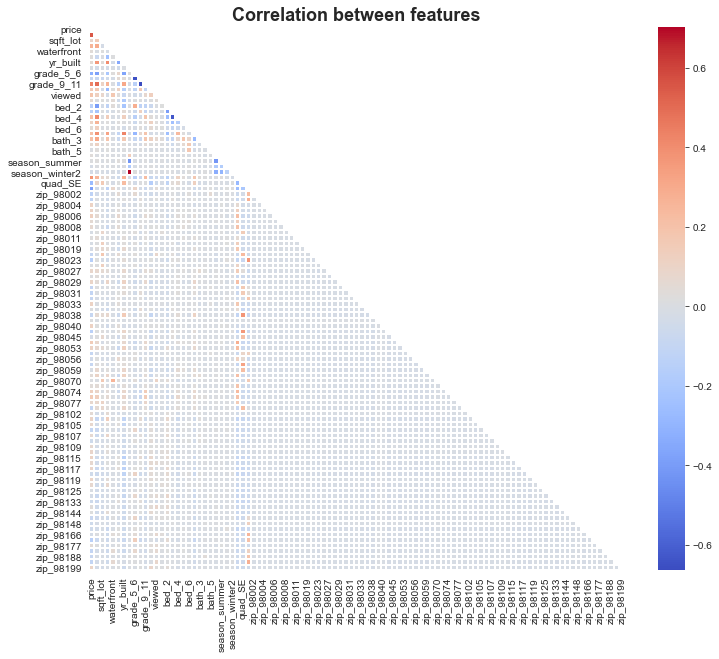

In [4]:
corr = df.corr()

plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

Let's see which features have the highest correlations.

In [5]:
df_corr_stack = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr_stack['pairs'] = list(zip(df_corr_stack.level_0, df_corr_stack.level_1))

df_corr_stack.set_index(['pairs'], inplace= True)

df_corr_stack.drop(columns= ['level_1', 'level_0'], inplace= True)
df_corr_stack.columns = ['cc']

df_corr_stack.drop_duplicates(inplace= True)

df_corr_stack[(df_corr_stack.cc > .55) & (df_corr_stack.cc < 1)]

,cc
pairs,
"(season_winter2, year_sold)",0.703979
"(grade_9_11, grade_7_8)",0.663331
"(grade_5_6, grade_7_8)",0.645486
"(bed_4, bed_3)",0.627719
"(price, sqft_living)",0.554367


#### Stepwise Selection

In [6]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        if not changed:
            break
    return included

In [7]:
# Comment out to reduce scrolling
# y = df['price']
# X = df.drop('price', axis= 1)

# result = stepwise_selection(X, y, verbose= True)
# print ('resulting features:')
# print (result)

The stepwise selection function suggested the following features:


|           |            |           |            |        |          |         |            |
|-----------|------------|-----------|------------|--------|----------|---------|------------|
|grade_5_6| yr_built |quad_SW|condition|sqft_living|bed_5 |bed_2   |had_renovation|
|grade_7_8| year_sold|quad_SE|floors   |sqft_lot   |bed_6 |bath_2|season_winter2 | 
|grade_9_11|yr_built |quad_NW|viewed|waterfront |bed_4 |bath_3  |79 zipcodes|


In [8]:
step_select_df = df[['price', 'quad_SE', 'quad_SW', 'sqft_living', 'grade_9_11', 
                     'viewed', 'zip_98106', 'condition', 'grade_7_8', 
                     'zip_98004', 'yr_built', 'zip_98155', 'zip_98133', 
                     'zip_98118', 'zip_98108', 'floors', 'zip_98040', 
                     'zip_98019', 'zip_98028', 'zip_98065', 'zip_98056', 
                     'zip_98178', 'zip_98126', 'zip_98034', 'zip_98125', 
                     'zip_98014', 'sqft_lot', 'zip_98146', 'zip_98011', 
                     'waterfront', 'zip_98072', 'zip_98166', 'year_sold', 
                     'zip_98112', 'zip_98119', 'zip_98024', 'zip_98199', 
                     'zip_98105', 'zip_98005', 'zip_98109', 'zip_98033', 
                     'zip_98103', 'zip_98115', 'zip_98117', 'zip_98107', 
                     'zip_98102', 'zip_98122', 'zip_98052', 'zip_98116', 
                     'has_basement', 'zip_98092', 'zip_98042', 'zip_98022', 
                     'zip_98006', 'zip_98023', 'zip_98030', 'had_renovation', 
                     'season_winter2', 'zip_98031', 'zip_98038', 'zip_98058', 
                     'zip_98002', 'zip_98168', 'zip_98003', 'zip_98032', 
                     'zip_98198', 'zip_98075', 'zip_98053', 'zip_98029', 
                     'zip_98055', 'zip_98188', 'bed_5', 'zip_98008', 
                     'zip_98074', 'zip_98027', 'zip_98007', 'zip_98136', 
                     'zip_98144', 'zip_98177', 'zip_98077', 'zip_98059', 
                     'zip_98045', 'zip_98070', 'zip_98010', 'zip_98039', 
                     'bed_6', 'bath_2', 'bath_3', 'zip_98148', 'quad_NW']]

#### Variance Inflation Factor

In [9]:
# check VIF (variance inflation factor)
# Consider removing features with VIF > 5 

# X = df.drop('price', axis= 1)

# vif_data = pd.DataFrame()
# vif_data['feature'] = X.columns

# vif_data['VIF'] = [vif(X.values, i) for i in range(len(X.columns))]

# print (vif_data[vif_data['VIF'] >= 5])

Stepwise Selection thought we could use some columns based on a low p-value. Variance Inflation Factor looked at the collinearity among the features. We will have to carefully consider both.

## Model 1: Has Everything

Only feature selection and engineering changes applied to baseline

In [10]:
y = df['price']
X = df.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)
df_train = pd.concat([X_train, y_train], axis= 1)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(14188, 98) (14188,)
(4730, 98) (4730,)


In [11]:
y = df_train['price']
X = df_train.drop('price', axis= 1)

X_int = sm.add_constant(X)
model= sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     607.9
Date:                Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:40:25   Log-Likelihood:            -1.7930e+05
No. Observations:               14188   AIC:                         3.588e+05
Df Residuals:                   14089   BIC:                         3.595e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.217e+07   4.62e+06    -13.452      0.000   -7.12e+07   -5.31e+07
sqft_living      117.1458      1.631     71.840      0.000     113.949     120.342
sqft_lot           0.4002      0.022     18.480      0.000       0.358       0.443
floors          -991.6231   1548.830     -0.640      0.522   -4027.535    2044.289
waterfront       1.86e+05   1.39e+04     13.352      0.000    1.59e+05    2.13e+05
condition       2.043e+04   1111.316     18.387      0.000    1.83e+04    2.26e+04
yr_built        -216.5821     35.171     -6.158      0.000    -285.522    -147.642
year_sold       3.107e+04   2294.215     13.544      0.000    2.66e+04    3.56e+04
grade_5_6      -4103.4473   1.63e+04     -0.252      0.801   -3.61e+04    2.79e+04
grade_7_8       2.917e+04   1.64e+04      1.783      0.075   -2901.427    6.12e+04
grade_9_11      1.038e+05   1.66e+04      6.255      0.000    7.13e+04    1.36e+05
has_basement   -1.637e+04   1624.202    -10.081      0.000   -1.96e+04   -1.32e+04
viewed          6.541e+04   2745.116     23.826      0.000       6e+04    7.08e+04
had_renovation  2.398e+04   4043.080      5.930      0.000    1.61e+04    3.19e+04
bed_2           2642.0305   6533.611      0.404      0.686   -1.02e+04    1.54e+04
bed_3           6827.9358   6536.379      1.045      0.296   -5984.231    1.96e+04
bed_4           5292.7016   6731.874      0.786      0.432   -7902.662    1.85e+04
bed_5          -1.616e+04   7244.264     -2.230      0.026   -3.04e+04   -1956.032
bed_6          -3.951e+04   9380.801     -4.212      0.000   -5.79e+04   -2.11e+04
bath_2          1.344e+04   1777.354      7.564      0.000    9960.285    1.69e+04
bath_3          1.793e+04   3243.276      5.530      0.000    1.16e+04    2.43e+04
bath_4          3305.4274   1.11e+04      0.299      0.765   -1.84e+04     2.5e+04
bath_5          5.166e+04   3.14e+04      1.645      0.100   -9888.280    1.13e+05
season_spring   3889.2244   2215.862      1.755      0.079    -454.158    8232.607
season_summer   5180.0665   2015.140      2.571      0.010    1230.125    9130.008
season_winter1  4279.2973   2873.833      1.489      0.136   -1353.796    9912.390
season_winter2 -1.465e+04   3152.232     -4.647      0.000   -2.08e+04   -8470.207
quad_NW        -1.865e+04   4811.890     -3.876      0.000   -2.81e+04   -9218.977
quad_SE          -6.5e+04   5745.356    -11.313      0.000   -7.63e+04   -5.37e+04
quad_SW        -4.597e+04   5433.857     -8.459      0.000   -5.66e+04   -3.53e+04
zip_98002       -778.7083   7600.156     -0.102      0.918   -1.57e+04    1.41e+04
zip_98003       8962.4711   6868.945      1.305      0.192   -4501.571    2.24e+04
zip_98004       4.339e+05   1.15e+04     37.605      0.000    4.11e+05    4.56e+05
zip_98005       3.095e+05   1.07e+04     28.923      0.000    2.89e+05    3.31e+05
zip_98006   

### RMSE & Accuracy

In [12]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  74486.09586679323
Test RMSE:  75483.7731737365


In [13]:
# Find accuracy of test and train sets
# Accuracy is % of predictions it got correct
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  80.8744217418826
Accuracy score - test: 80.93843428585029


### Q-Q Plot

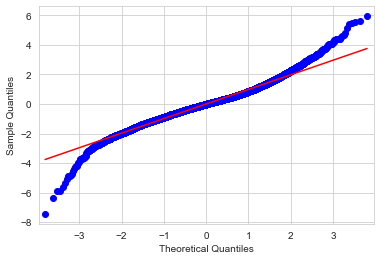

In [14]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig.show()

That Q-Q plot shows we have some thin 'tails' on our data.

While this model looks better than the baseline on a Q-Q plot and gives an okay $R^2$ value, we have to remember it doesn't meet the assumption of having little to no multicollinearity and still has features that are not statistically significant.

## Model 2: Remove Almost Everything
Select features suggested by stepwise selection function while removing those that may cause multicollinearity indicated by VIF.

In [15]:
df1 = step_select_df.copy()

In [16]:
df1.columns

Index(['price', 'quad_SE', 'quad_SW', 'sqft_living', 'grade_9_11', 'viewed',
       'zip_98106', 'condition', 'grade_7_8', 'zip_98004', 'yr_built',
       'zip_98155', 'zip_98133', 'zip_98118', 'zip_98108', 'floors',
       'zip_98040', 'zip_98019', 'zip_98028', 'zip_98065', 'zip_98056',
       'zip_98178', 'zip_98126', 'zip_98034', 'zip_98125', 'zip_98014',
       'sqft_lot', 'zip_98146', 'zip_98011', 'waterfront', 'zip_98072',
       'zip_98166', 'year_sold', 'zip_98112', 'zip_98119', 'zip_98024',
       'zip_98199', 'zip_98105', 'zip_98005', 'zip_98109', 'zip_98033',
       'zip_98103', 'zip_98115', 'zip_98117', 'zip_98107', 'zip_98102',
       'zip_98122', 'zip_98052', 'zip_98116', 'has_basement', 'zip_98092',
       'zip_98042', 'zip_98022', 'zip_98006', 'zip_98023', 'zip_98030',
       'had_renovation', 'season_winter2', 'zip_98031', 'zip_98038',
       'zip_98058', 'zip_98002', 'zip_98168', 'zip_98003', 'zip_98032',
       'zip_98198', 'zip_98075', 'zip_98053', 'zip_98029', 'zip

In [17]:
df1 = df1.drop(columns= ['sqft_living', 'floors', 'condition', 'yr_built',
         'grade_9_11', 'grade_7_8', 'bed_5', 'quad_SE', 'quad_SW', 'quad_NW'], 
         axis= 1)

In [18]:
y = df1['price']
X = df1.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)
df_train1 = pd.concat([X_train, y_train], axis= 1)

In [19]:
y = df_train1['price']
X = df_train1.drop('price', axis= 1)

X_int = sm.add_constant(X)
model1= sm.OLS(y, X_int).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     294.7
Date:                Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:40:25   Log-Likelihood:            -1.8412e+05
No. Observations:               14188   AIC:                         3.684e+05
Df Residuals:                   14108   BIC:                         3.690e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5.124e+07   5.34e+06     -9.603      0.000   -6.17e+07   -4.08e+07
viewed          1.133e+05   3792.793     29.875      0.000    1.06e+05    1.21e+05
zip_98106       5.349e+04   9280.926      5.763      0.000    3.53e+04    7.17e+04
zip_98004       4.774e+05   1.44e+04     33.049      0.000    4.49e+05    5.06e+05
zip_98155       1.297e+05   8769.293     14.792      0.000    1.13e+05    1.47e+05
zip_98133       1.336e+05   8505.235     15.702      0.000    1.17e+05     1.5e+05
zip_98118       1.262e+05   8553.232     14.755      0.000    1.09e+05    1.43e+05
zip_98108        8.82e+04   1.11e+04      7.962      0.000    6.65e+04     1.1e+05
zip_98040       4.527e+05   1.46e+04     30.966      0.000    4.24e+05    4.81e+05
zip_98019       1.106e+05   1.09e+04     10.118      0.000    8.91e+04    1.32e+05
zip_98028       1.659e+05   9757.121     17.005      0.000    1.47e+05    1.85e+05
zip_98065       1.882e+05   9727.404     19.352      0.000    1.69e+05    2.07e+05
zip_98056       1.208e+05   8834.733     13.674      0.000    1.03e+05    1.38e+05
zip_98178       2.098e+04   1.03e+04      2.032      0.042     742.122    4.12e+04
zip_98126       1.438e+05   9103.913     15.792      0.000    1.26e+05    1.62e+05
zip_98034       1.806e+05   8396.660     21.507      0.000    1.64e+05    1.97e+05
zip_98125       1.701e+05   8849.344     19.221      0.000    1.53e+05    1.87e+05
zip_98014       1.106e+05   1.36e+04      8.130      0.000     8.4e+04    1.37e+05
sqft_lot           0.6742      0.030     22.498      0.000       0.615       0.733
zip_98146       6.437e+04   9848.707      6.536      0.000    4.51e+04    8.37e+04
zip_98011       1.927e+05   1.04e+04     18.518      0.000    1.72e+05    2.13e+05
waterfront      1.673e+05   1.95e+04      8.568      0.000    1.29e+05    2.06e+05
zip_98072       2.147e+05      1e+04     21.443      0.000    1.95e+05    2.34e+05
zip_98166       1.047e+05   1.06e+04      9.914      0.000     8.4e+04    1.25e+05
year_sold       2.554e+04   2649.189      9.642      0.000    2.03e+04    3.07e+04
zip_98112       3.785e+05   1.31e+04     28.899      0.000    3.53e+05    4.04e+05
zip_98119       3.318e+05   1.22e+04     27.257      0.000    3.08e+05    3.56e+05
zip_98024       1.461e+05    1.6e+04      9.120      0.000    1.15e+05    1.78e+05
zip_98199       3.116e+05   1.05e+04     29.730      0.000    2.91e+05    3.32e+05
zip_98105        3.42e+05   1.23e+04     27.894      0.000    3.18e+05    3.66e+05
zip_98005       3.833e+05   1.26e+04     30.538      0.000    3.59e+05    4.08e+05
zip_98109       3.455e+05   1.66e+04     20.787      0.000    3.13e+05    3.78e+05
zip_98033       3.022e+05   9678.944     31.227      0.000    2.83e+05    3.21e+05
zip_98103       2.731e+05   8332.134     32.777      0.000    2.57e+05    2.89e+05
zip_98115   

Ouch! Felt that right in the $R^2$! All of the calculation's scores dropped - some more significantly than others. Kurtosis is in the 3 range now - indicating the data is more normally distributed. The Jarque-Bera (JB) (another normality test) is five times less than what it was in the first model.

### RMSE & Accuracy

In [20]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  104625.2349313531
Test RMSE:  107164.84197164388


In [21]:
# Find accuracy of test and train sets
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  62.265635181892605
Accuracy score - test: 61.580118186502084


### Q-Q Plot

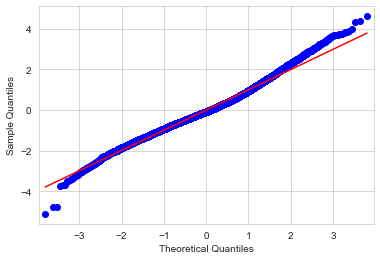

In [22]:
residuals = model1.resid
fig1 = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig1.show()

### Correlation Matrix

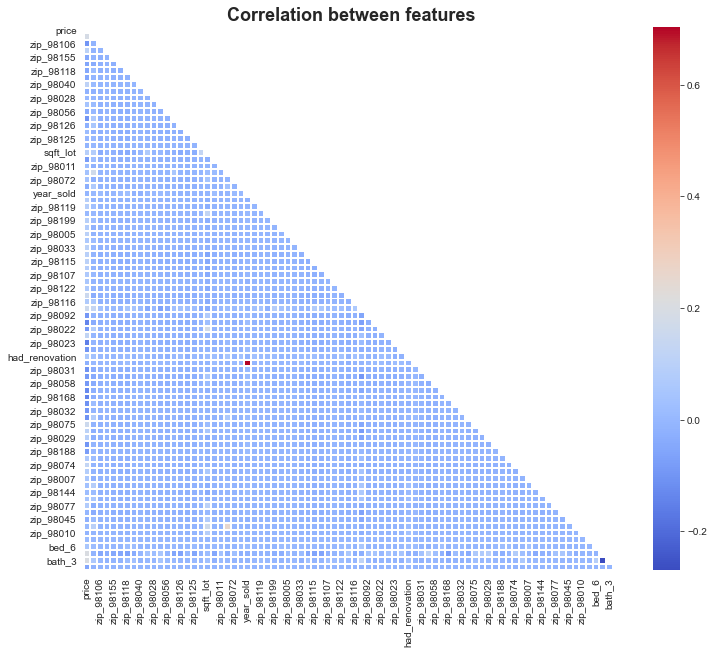

In [23]:
corr = df1.corr()

plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df1.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

While this model meets normality assumptions better than the other model, it is does a poorer job at predicting housing prices.

## Model 3:  Not Using Zip Codes
Create a model that doesn't use zip codes, only quadrants created from latitude and longitude.

In [24]:
df_no_zip = df[['price', 'viewed', 'condition', 'waterfront', 'floors', 
          'grade_5_6', 'grade_9_11', 'quad_SE', 'quad_SW', 'yr_built', 
          'sqft_living', 'bath_2', 'bed_5', 'sqft_lot', 'bed_2', 
          'had_renovation']]

In [25]:
y = df_no_zip['price']
X = df_no_zip.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                    random_state = 42)
df_train_nozip = pd.concat([X_train, y_train], axis= 1)

In [26]:
y = df_train_nozip['price']
X = df_train_nozip.drop('price', axis= 1)

X_int = sm.add_constant(X)
model_nozip = sm.OLS(y, X_int).fit()
model_nozip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     1858.
Date:                Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:40:27   Log-Likelihood:            -1.8332e+05
No. Observations:               14188   AIC:                         3.667e+05
Df Residuals:                   14172   BIC:                         3.668e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.779e+06   7.92e+04     22.472      0.000    1.62e+06    1.93e+06
viewed          5.923e+04   3495.914     16.943      0.000    5.24e+04    6.61e+04
condition       2.178e+04   1419.795     15.343      0.000     1.9e+04    2.46e+04
waterfront      1.922e+05   1.79e+04     10.746      0.000    1.57e+05    2.27e+05
floors          2.453e+04   1694.609     14.475      0.000    2.12e+04    2.79e+04
grade_5_6       -7.16e+04   2989.027    -23.953      0.000   -7.75e+04   -6.57e+04
grade_9_11      9.544e+04   3036.476     31.430      0.000    8.95e+04    1.01e+05
quad_SE        -1.671e+05   2349.128    -71.124      0.000   -1.72e+05   -1.62e+05
quad_SW        -1.905e+05   2396.797    -79.488      0.000   -1.95e+05   -1.86e+05
yr_built        -816.8656     39.787    -20.531      0.000    -894.854    -738.877
sqft_living      109.3875      1.719     63.644      0.000     106.019     112.756
bath_2          1.161e+04   1961.353      5.917      0.000    7761.399    1.55e+04
bed_5          -2.185e+04   3736.484     -5.848      0.000   -2.92e+04   -1.45e+04
sqft_lot           0.3200      0.027     12.044      0.000       0.268       0.372
bed_2           1.263e+04   2674.636      4.722      0.000    7386.530    1.79e+04
had_renovation  2.174e+04   5296.984      4.104      0.000    1.14e+04    3.21e+04
==============================================================================
Omnibus:                      455.209   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.054
Skew:                           0.312   Prob(JB):                    3.56e-153
Kurtosis:                       3.893   Cond. No.                     3.35e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### RMSE & Accuracy

In [27]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  98880.70329606616
Test RMSE:  100884.39335475277


In [28]:
# Find accuracy of test and train sets
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  66.29554997122385
Accuracy score - test: 65.95139349250971


### Q-Q Plot

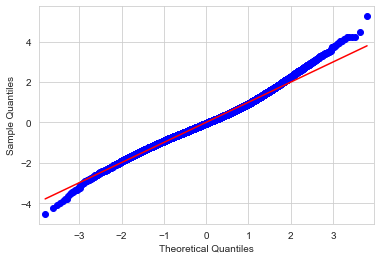

In [29]:
residuals = model_nozip.resid
fig2 = sm.graphics.qqplot(residuals, dist= stats.norm, line= 'r', fit= True)
fig2.show()

We see a drop in RMSE and accuracy in predictions from the first model, but do respect some normality assumptions. However, it appears have zip codes dramatically increases our ability to predict the prices.

## Model 4: Using Zip Codes
To get better at predicting prices, we will include the zip codes, but eliminate features that are not statistically significant.

In [30]:
df2 = step_select_df.copy()

In [31]:
# df2.columns

In [32]:
# remove features that have multicollinearity, very high VIF, 
# or p-value > 0.05
df2 = df2.drop(columns= ['year_sold', 'grade_7_8', 'zip_98092', 'zip_98023', 
                         'zip_98002', 'zip_98003', 'zip_98032', 'floors', 
                         'season_winter2', 'quad_NW'], axis= 1)

In [33]:
y = df2['price']
X = df2.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                    random_state = 32)
df_train2 = pd.concat([X_train, y_train], axis= 1)

In [34]:
y = df_train2['price']
X = df_train2.drop('price', axis= 1)

X_int = sm.add_constant(X)
model2 = sm.OLS(y, X_int).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     726.8
Date:                Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:40:27   Log-Likelihood:            -1.7956e+05
No. Observations:               14188   AIC:                         3.593e+05
Df Residuals:                   14108   BIC:                         3.599e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.539e+05   6.61e+04      2.327      0.020    2.42e+04    2.84e+05
quad_SE        -5.391e+04   4499.086    -11.982      0.000   -6.27e+04   -4.51e+04
quad_SW        -4.415e+04   4768.945     -9.258      0.000   -5.35e+04   -3.48e+04
sqft_living      123.1040      1.419     86.745      0.000     120.322     125.886
grade_9_11      6.978e+04   2398.524     29.093      0.000    6.51e+04    7.45e+04
viewed          6.271e+04   2746.337     22.835      0.000    5.73e+04    6.81e+04
zip_98106       6.356e+04   6968.542      9.121      0.000    4.99e+04    7.72e+04
condition       1.977e+04   1113.547     17.753      0.000    1.76e+04     2.2e+04
zip_98004       4.126e+05    1.1e+04     37.665      0.000    3.91e+05    4.34e+05
yr_built         -74.2642     32.766     -2.266      0.023    -138.490     -10.038
zip_98155       9.712e+04   6546.788     14.835      0.000    8.43e+04     1.1e+05
zip_98133       1.102e+05   6401.588     17.216      0.000    9.77e+04    1.23e+05
zip_98118       1.105e+05   6491.234     17.028      0.000    9.78e+04    1.23e+05
zip_98108       6.803e+04   8213.725      8.282      0.000    5.19e+04    8.41e+04
zip_98040       3.705e+05    1.1e+04     33.831      0.000    3.49e+05    3.92e+05
zip_98019       5.653e+04   8227.465      6.871      0.000    4.04e+04    7.27e+04
zip_98028       1.038e+05   7190.093     14.431      0.000    8.97e+04    1.18e+05
zip_98065       9.907e+04   7134.360     13.886      0.000    8.51e+04    1.13e+05
zip_98056       7.227e+04   6042.964     11.960      0.000    6.04e+04    8.41e+04
zip_98178       2.424e+04   6192.375      3.915      0.000    1.21e+04    3.64e+04
zip_98126       1.373e+05   6920.659     19.845      0.000    1.24e+05    1.51e+05
zip_98034       1.424e+05   6273.080     22.704      0.000     1.3e+05    1.55e+05
zip_98125       1.567e+05   6716.464     23.333      0.000    1.44e+05     1.7e+05
zip_98014       4.604e+04   9387.908      4.904      0.000    2.76e+04    6.44e+04
sqft_lot           0.4390      0.022     19.565      0.000       0.395       0.483
zip_98146        7.01e+04   6413.569     10.929      0.000    5.75e+04    8.27e+04
zip_98011       1.185e+05   8113.026     14.612      0.000    1.03e+05    1.34e+05
waterfront      1.875e+05   1.52e+04     12.363      0.000    1.58e+05    2.17e+05
zip_98072       1.399e+05   7545.386     18.546      0.000    1.25e+05    1.55e+05
zip_98166       1.007e+05   6285.391     16.018      0.000    8.84e+04    1.13e+05
zip_98112        3.43e+05   9885.618     34.692      0.000    3.24e+05    3.62e+05
zip_98119       3.338e+05   9426.834     35.409      0.000    3.15e+05    3.52e+05
zip_98024       9.362e+04   1.19e+04      7.900      0.000    7.04e+04    1.17e+05
zip_98199       2.978e+05   7751.509     38.422      0.000    2.83e+05    3.13e+05
zip_98105   

### RMSE & Accuracy

In [35]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  75855.08105900817
Test RMSE:  76884.35449113935


In [36]:
# Find accuracy of test and train sets
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  80.2750209211953
Accuracy score - test: 79.8978512515584


### Q-Q Plot

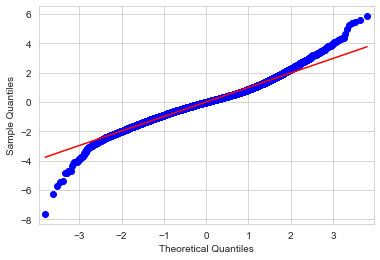

In [37]:
residuals = model2.resid
fig2 = sm.graphics.qqplot(residuals, dist= stats.norm, line= 'r', fit= True)
fig2.show()

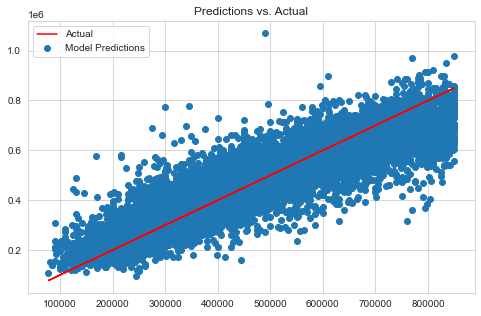

In [38]:
y_pred = linreg.predict(X_train)

# Create a matplotlib figure
plt.figure(figsize=(8, 5))
# Create a scatter plot
plt.scatter(y_train, y_pred, label='Model Predictions')
plt.plot(y_train, y_train, label='Actual', color='r')
plt.title('Predictions vs. Actual')
plt.legend()
plt.show()

Our predictions are fairly close and 80% of the variations can be explained by this model, the data is still not normally distributed. Let's try to fix those "thin tails".

## Model 5: Log Transform Model 4

In [39]:
df3 = df2.copy()

In [40]:
df3.columns

Index(['price', 'quad_SE', 'quad_SW', 'sqft_living', 'grade_9_11', 'viewed',
       'zip_98106', 'condition', 'zip_98004', 'yr_built', 'zip_98155',
       'zip_98133', 'zip_98118', 'zip_98108', 'zip_98040', 'zip_98019',
       'zip_98028', 'zip_98065', 'zip_98056', 'zip_98178', 'zip_98126',
       'zip_98034', 'zip_98125', 'zip_98014', 'sqft_lot', 'zip_98146',
       'zip_98011', 'waterfront', 'zip_98072', 'zip_98166', 'zip_98112',
       'zip_98119', 'zip_98024', 'zip_98199', 'zip_98105', 'zip_98005',
       'zip_98109', 'zip_98033', 'zip_98103', 'zip_98115', 'zip_98117',
       'zip_98107', 'zip_98102', 'zip_98122', 'zip_98052', 'zip_98116',
       'has_basement', 'zip_98042', 'zip_98022', 'zip_98006', 'zip_98030',
       'had_renovation', 'zip_98031', 'zip_98038', 'zip_98058', 'zip_98168',
       'zip_98198', 'zip_98075', 'zip_98053', 'zip_98029', 'zip_98055',
       'zip_98188', 'bed_5', 'zip_98008', 'zip_98074', 'zip_98027',
       'zip_98007', 'zip_98136', 'zip_98144', 'zip_98177

In [41]:
# list of continuous features to log transform
cont = ['yr_built', 'sqft_living', 'sqft_lot']

In [42]:
df_cont = df3[cont]

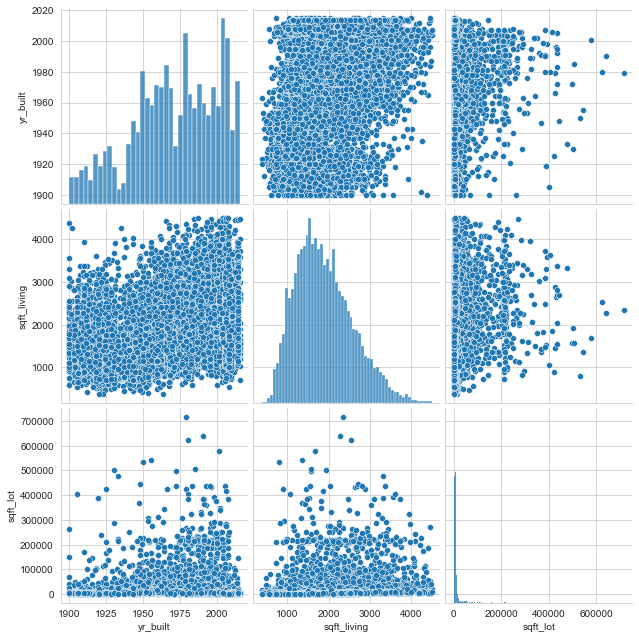

In [43]:
cont_pp = sns.pairplot(df_cont, height= 3)

Yikes. "sqft_living" is the only semi-normalish distribution.

In [44]:
log_names = [f'{column}_log' for column in df_cont.columns]

df_cont_log = np.log(df_cont)
df_cont_log.columns = log_names

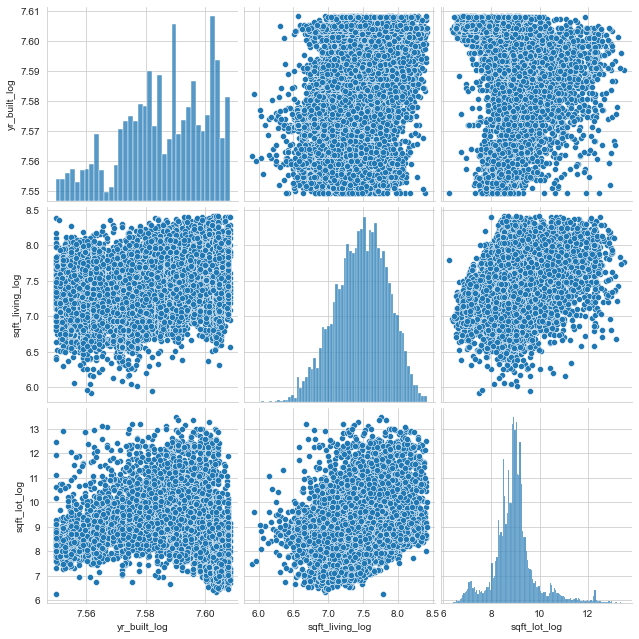

In [45]:
cont_pp2 = sns.pairplot(df_cont_log, height= 3)

"sqft_living" looks better and so does "sqft_lot". "yr_built" is still a bit messy, but better.

In [46]:
model4_log = pd.concat([df_cont_log, df3], axis= 1)
model4_log.head()

,yr_built_log,sqft_living_log,sqft_lot_log,price,quad_SE,quad_SW,sqft_living,grade_9_11,viewed,zip_98106,condition,zip_98004,yr_built,zip_98155,zip_98133,zip_98118,zip_98108,zip_98040,zip_98019,zip_98028,zip_98065,zip_98056,zip_98178,zip_98126,zip_98034,zip_98125,zip_98014,sqft_lot,zip_98146,zip_98011,waterfront,zip_98072,zip_98166,zip_98112,zip_98119,zip_98024,zip_98199,zip_98105,zip_98005,zip_98109,zip_98033,zip_98103,zip_98115,zip_98117,zip_98107,zip_98102,zip_98122,zip_98052,zip_98116,has_basement,zip_98042,zip_98022,zip_98006,zip_98030,had_renovation,zip_98031,zip_98038,zip_98058,zip_98168,zip_98198,zip_98075,zip_98053,zip_98029,zip_98055,zip_98188,bed_5,zip_98008,zip_98074,zip_98027,zip_98007,zip_98136,zip_98144,zip_98177,zip_98077,zip_98059,zip_98045,zip_98070,zip_98010,zip_98039,bed_6,bath_2,bath_3,zip_98148
0,7.578145,7.073270,8.639411,221900.0,0,0,1180,0,0,0,3,0,1955,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.576097,7.851661,8.887653,538000.0,0,0,2570,0,0,0,3,0,1951,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,7.566828,6.646391,9.210340,180000.0,0,0,770,0,0,0,3,0,1933,0,0,0,0,0,0,1,0,0,0,0,0,0,0,10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7.583248,7.580700,8.517193,604000.0,0,0,1960,0,0,0,5,0,1965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,7.594381,7.426549,8.997147,510000.0,0,0,1680,0,0,0,3,0,1987,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8080,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [47]:
model4_log.drop(columns= ['yr_built', 'sqft_living', 'sqft_lot'], 
                inplace= True)

### Train, test split

In [48]:
y = model4_log['price']
X = model4_log.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)
df_train3 = pd.concat([X_train, y_train], axis= 1)

In [49]:
y = df_train3['price']
X = df_train3.drop('price', axis= 1)

X_int = sm.add_constant(X)
model3 = sm.OLS(y, X_int).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     738.0
Date:                Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:40:34   Log-Likelihood:            -1.7943e+05
No. Observations:               14188   AIC:                         3.590e+05
Df Residuals:                   14108   BIC:                         3.596e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -3.05e+06   5.18e+05     -5.889      0.000   -4.07e+06   -2.04e+06
yr_built_log     1.995e+05   6.79e+04      2.937      0.003    6.64e+04    3.33e+05
sqft_living_log  2.067e+05   2607.547     79.260      0.000    2.02e+05    2.12e+05
sqft_lot_log     2.609e+04   1033.896     25.239      0.000    2.41e+04    2.81e+04
quad_SE         -5.663e+04   4586.319    -12.348      0.000   -6.56e+04   -4.76e+04
quad_SW         -4.544e+04   4845.860     -9.377      0.000   -5.49e+04   -3.59e+04
grade_9_11       8.629e+04   2304.154     37.452      0.000    8.18e+04    9.08e+04
viewed           6.745e+04   2756.041     24.473      0.000     6.2e+04    7.28e+04
zip_98106        8.469e+04   7025.890     12.053      0.000    7.09e+04    9.85e+04
condition        1.874e+04   1111.591     16.862      0.000    1.66e+04    2.09e+04
zip_98004        4.246e+05   1.06e+04     40.130      0.000    4.04e+05    4.45e+05
zip_98155        1.017e+05   6627.868     15.340      0.000    8.87e+04    1.15e+05
zip_98133        1.225e+05   6454.480     18.978      0.000     1.1e+05    1.35e+05
zip_98118        1.328e+05   6569.812     20.220      0.000     1.2e+05    1.46e+05
zip_98108        9.007e+04   8268.038     10.893      0.000    7.39e+04    1.06e+05
zip_98040         3.59e+05   1.07e+04     33.543      0.000    3.38e+05     3.8e+05
zip_98019        5.175e+04   8113.989      6.378      0.000    3.58e+04    6.77e+04
zip_98028        1.051e+05   7282.608     14.431      0.000    9.08e+04    1.19e+05
zip_98065        1.083e+05   7263.777     14.914      0.000    9.41e+04    1.23e+05
zip_98056         7.95e+04   5999.051     13.251      0.000    6.77e+04    9.13e+04
zip_98178        3.288e+04   6525.928      5.038      0.000    2.01e+04    4.57e+04
zip_98126        1.605e+05   6922.170     23.192      0.000    1.47e+05    1.74e+05
zip_98034        1.435e+05   6353.006     22.584      0.000    1.31e+05    1.56e+05
zip_98125        1.581e+05   6694.354     23.619      0.000    1.45e+05    1.71e+05
zip_98014        5.625e+04      1e+04      5.621      0.000    3.66e+04    7.59e+04
zip_98146        7.971e+04   6434.120     12.388      0.000    6.71e+04    9.23e+04
zip_98011        1.207e+05   7737.315     15.604      0.000    1.06e+05    1.36e+05
waterfront        1.74e+05    1.4e+04     12.407      0.000    1.46e+05    2.01e+05
zip_98072        1.308e+05   7490.594     17.467      0.000    1.16e+05    1.46e+05
zip_98166        1.038e+05   6395.767     16.225      0.000    9.12e+04    1.16e+05
zip_98112        3.777e+05   9779.401     38.623      0.000    3.59e+05    3.97e+05
zip_98119        3.526e+05   9128.212     38.627      0.000    3.35e+05     3.7e+05
zip_98024        9.676e+04   1.17e+04      8.268      0.000    7.38e+04     1.2e+05
zip_98199        3.083e+05   7874.388     39.150      0.000

### RMSE & Accuracy

In [50]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  75178.39264548299
Test RMSE:  76742.9759460677


In [51]:
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  80.51725153270131
Accuracy score - test: 80.29716858307113


### Q-Q Plot

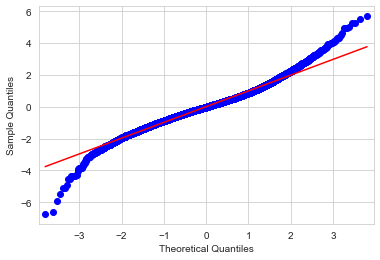

In [52]:
# Q-Q plot
residuals = model3.resid
fig3 = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig3.show()

The "tails" on the Q-Q plot are closer to normal, but the model is not that much better at predicting house prices than the model without a log transformation. Let's use the model that hasn't been log-transformed going forward to easily understand the features.

## Model 6: Remove Outliers 
AKA: Fix those tails!

In [53]:
# Removing outliers will mean some features will not have data 
# these are the features that will be left
df5 = df[['price', 'quad_SE', 'quad_SW', 'sqft_living', 'grade_9_11',
       'condition', 'yr_built', 'sqft_lot',
       'bath_2', 'floors', 'bed_2']]

In [54]:
# Remove everything after 3 standard deviations
df5 = df5[(np.abs(stats.zscore(df5)) < 3).all(axis=1)]

In [55]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18476 entries, 0 to 18917
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        18476 non-null  float64
 1   quad_SE      18476 non-null  int64  
 2   quad_SW      18476 non-null  int64  
 3   sqft_living  18476 non-null  int64  
 4   grade_9_11   18476 non-null  int64  
 5   condition    18476 non-null  int64  
 6   yr_built     18476 non-null  int64  
 7   sqft_lot     18476 non-null  int64  
 8   bath_2       18476 non-null  int64  
 9   floors       18476 non-null  int64  
 10  bed_2        18476 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.7 MB


We didn't lose a lot of data doing that. Nice!
Let's see how it affects our model.

In [56]:
y = df5['price']
X = df5.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 32)
df_train5 = pd.concat([X_train, y_train], axis= 1)

In [57]:
y = df_train5['price']
X = df_train5.drop('price', axis= 1)

X_int = sm.add_constant(X)
model5 = sm.OLS(y, X_int).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     2428.
Date:                Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:40:34   Log-Likelihood:            -1.7958e+05
No. Observations:               13857   AIC:                         3.592e+05
Df Residuals:                   13846   BIC:                         3.593e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.599e+06   7.83e+04     20.424      0.000    1.45e+06    1.75e+06
quad_SE     -1.749e+05   2490.091    -70.252      0.000    -1.8e+05    -1.7e+05
quad_SW     -1.941e+05   2490.081    -77.952      0.000   -1.99e+05   -1.89e+05
sqft_living   121.2928      1.749     69.349      0.000     117.864     124.721
grade_9_11   9.278e+04   3195.221     29.039      0.000    8.65e+04     9.9e+04
condition    2.093e+04   1502.624     13.931      0.000     1.8e+04    2.39e+04
yr_built     -739.6783     39.448    -18.751      0.000    -817.001    -662.355
sqft_lot        0.5768      0.080      7.217      0.000       0.420       0.734
bath_2       1.499e+04   2066.362      7.252      0.000    1.09e+04     1.9e+04
floors       2.617e+04   1805.617     14.493      0.000    2.26e+04    2.97e+04
bed_2        5515.1561   2795.661      1.973      0.049      35.283     1.1e+04
==============================================================================
Omnibus:                      478.924   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.080
Skew:                           0.347   Prob(JB):                    9.54e-153
Kurtosis:                       3.854   Cond. No.                     1.39e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### RMSE & Accuracy

In [58]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  102830.26825614936
Test RMSE:  101633.07100466779


In [59]:
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  63.68439987976458
Accuracy score - test: 63.77027827948969


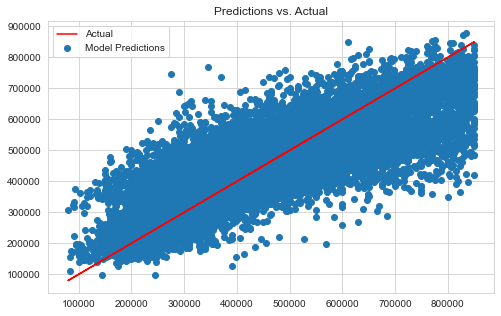

In [60]:
# Get predictions
y_pred = linreg.predict(X_train)

# Create a matplotlib figure
plt.figure(figsize=(8, 5))
# Create a scatter plot
plt.scatter(y_train, y_pred, label='Model Predictions')
plt.plot(y_train, y_train, label='Actual', color='r')
plt.title('Predictions vs. Actual')
plt.legend()
plt.show()

### Q-Q Plot

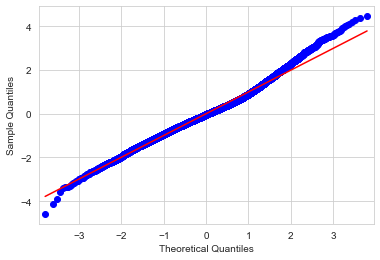

In [61]:
residuals = model5.resid
fig5 = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig5.show()

### Check regression assumptions in error terms

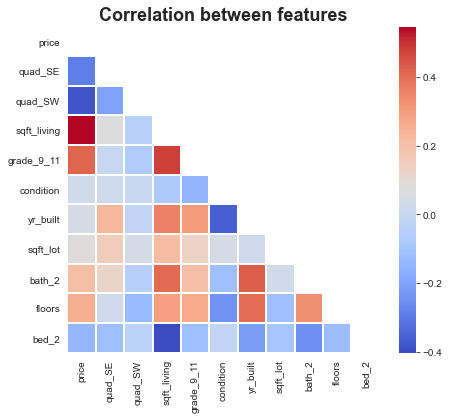

In [62]:
corr = df5.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df5.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

While this data is the most normally distributed, it does a poorer job at predicting sale prices, with only being able to explain 63.7% of variations in price and having a larger range of error. This is similar to our model where we did not use zip codes. As you can see, this model did not use zip codes either and it definitely affects the model's efficacy.

## Winning Model -- 4

Due to it's ease of interpretation and accuracy, it is the model that would be most useful to predict home sale prices in King County for first time home buyers.

quad_SE


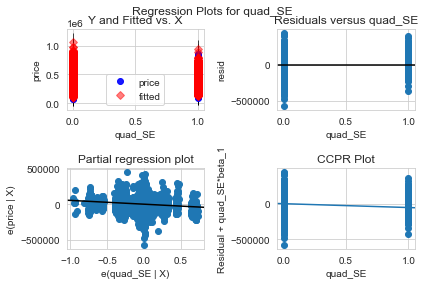

quad_SW


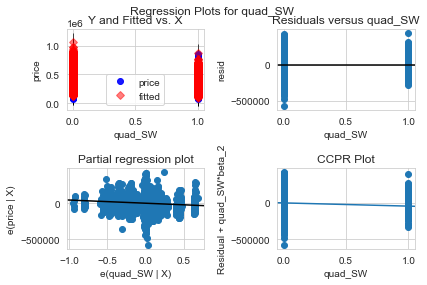

sqft_living


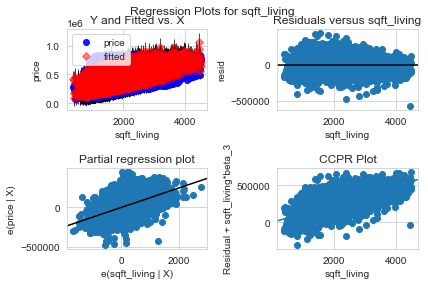

grade_9_11


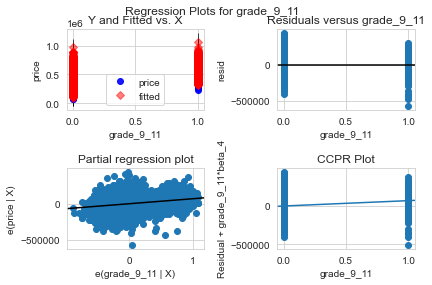

viewed


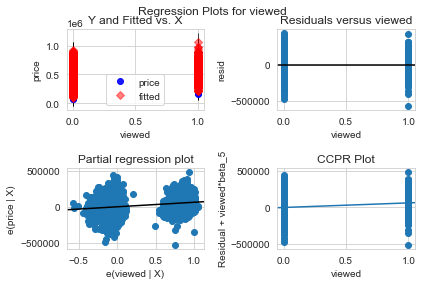

condition


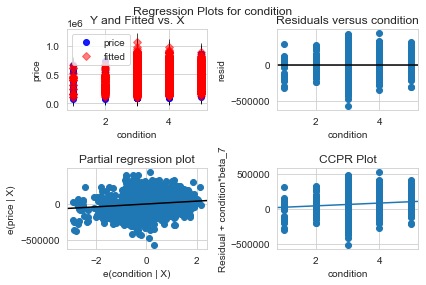

zip_98004


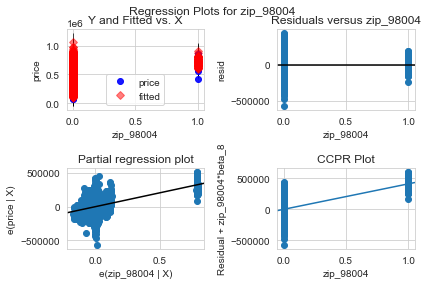

yr_built


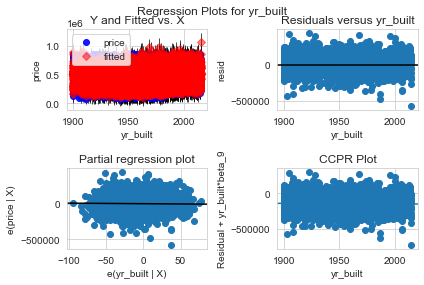

waterfront


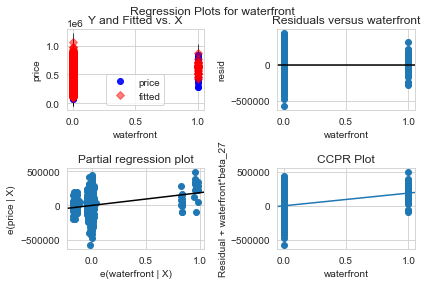

has_basement


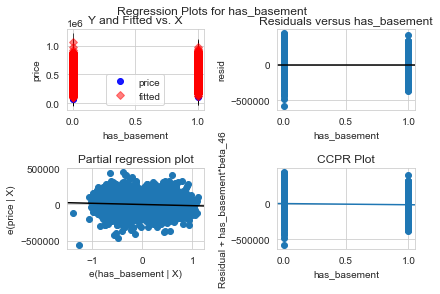

had_renovation


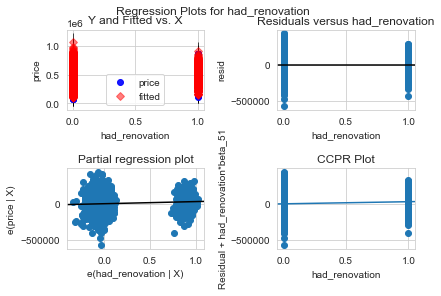

bed_6


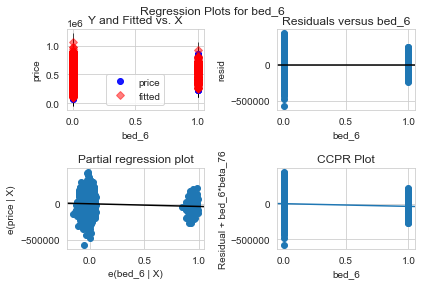

bath_2


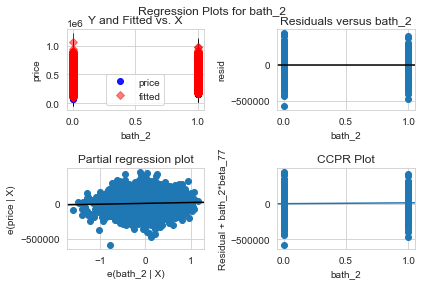

bath_3


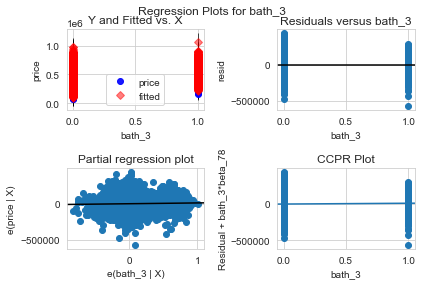

In [63]:
labels = ['quad_SE', 'quad_SW', 'sqft_living', 'grade_9_11', 'viewed',
          'condition', 'zip_98004', 'yr_built', 'waterfront', 'has_basement',
          'had_renovation', 'bed_6', 'bath_2', 'bath_3']

for ind, i in enumerate(labels):
    print (labels[ind])
    sm.graphics.plot_regress_exog(model2, i)
    plt.show()

## Conclusion

The model that does the best at predicting house sale prices for first time home buyers was the fourth model. Interestingly, this model did not need any normalization or log transformations to perform better.

The model can explain 80% of variations in price and the average error is around \\$76,884.

* The model shows a relationship between sale price and the year a house was built. One might expect a house's value to go down approximately \\$74 every year it gets older.

* The model also shows that increasing the size of your home will increase the value. For every square foot of living space, one could expect an extra \\$123 on the sale price.

* Adding square footage to the lot does increase the value of property- about .44 cents for every square foot. That may not sound like a lot of money, but we kept lots that were up to 750,000 square feet. That can add up if you have a lot of land.

* Having a property in the zip code 98022 will increase the cost of a home by approximately \\$8150. This is a very large zip code and is close to the base of Mt. Ranier. These factors may impact the home prices in this region.

**_Recommendations to First Time Home Buyers:_**

* First time home buyers should make sure they are buying houses between the months of October through March to avoid paying more for the same house the in spring and summer months.

* They may also choose to look at homes south of longitude 47.5 if they are looking to spend less.

* Most houses have average or higher than average grades and conditions. Houses should be "move-in ready" in most cases.

* If the buyer is wanting extra features like properties on the water, they may have to wait longer or choose from a limited selection.

* Find properties on your own or use alternative methods. Houses that are viewed by more people end up costing more - from \\$128,000 to \\$201,000, on average.

## Future Work

Other topics that would be good to evaluate for first time home buyers in the future include: 
* Commute times
* Surrounding amenities such as schools, parks, restaurants, grocery stores, hospitals and other places of interest 
* Vicinity to public transportation or walk-ability
* Comparing to newer data
* Estimating other costs like home insurance and taxes